In [2]:
!conda install -c conda-forge librosa -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/pytorch_p36

  added / updated specs: 
    - librosa


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    tk-8.6.10                  |       hed695b0_0         3.2 MB  conda-forge
    joblib-0.14.1              |             py_0         198 KB  conda-forge
    libvorbis-1.3.5            |    h516909a_1002         624 KB  conda-forge
    expat-2.2.9                |       he1b5a44_2         191 KB  conda-forge
    krb5-1.16.4                |       h2fd8d38_0         1.4 MB  conda-forge
    cryptography-2.8           |   py36h72c5cf5_1         616 KB  conda-forge
    libsndfile-1.0.28          |    he1b5a44_1000 

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import soundfile as sf
#import sounddevice as sd
import queue
import boto3
import json
import io
import scipy.io.wavfile as sciwav

In [138]:
def extract_features(bucket, wav_key, feat='mfcc'):
    s3 = boto3.resource('s3')
    obj = s3.Object(bucket, wav_key)
    sample_rate, X = sciwav.read(io.BytesIO(obj.get()['Body'].read()))
    X = X.astype(np.float32)

    
    if feat == 'mfcc':
        features = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
    elif feat == 'mel':
        features = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_fft=1024, hop_length=256)
    else:
        raise Exception('feat must be "mfcc" or "mel"')
    
    return features

In [49]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket='music-ml-gigioli', Key='data/nsynth/nsynth-train/examples.json')

train_examples = json.loads(obj['Body'].read().decode('utf-8'))

In [161]:
len([k for k, v in train_examples.items() if v['instrument_source'] == 0])

102165

In [167]:
%%timeit
_ = extract_features('music-ml-gigioli', 'data/nsynth/nsynth-train/audio/{}.wav'.format(k))

68.8 ms ± 14.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [171]:
0.0688 * 100000 / 60 / 60

1.9111111111111112

In [166]:
mfccs = []
for i, x in enumerate(train_examples.items()):
    k, v = x
    mfccs.append(extract_features('music-ml-gigioli', 'data/nsynth/nsynth-train/audio/{}.wav'.format(k)))
    
    if i+1 % 1000 == 0:
        print(i+1)

KeyboardInterrupt: 

In [160]:
train_examples[list(train_examples.keys())[18]]

{'note': 281566,
 'sample_rate': 16000,
 'pitch': 92,
 'instrument_source': 2,
 'instrument_family_str': 'bass',
 'instrument_str': 'bass_synthetic_037',
 'note_str': 'bass_synthetic_037-092-050',
 'qualities_str': ['distortion'],
 'instrument_source_str': 'synthetic',
 'velocity': 50,
 'instrument_family': 0,
 'instrument': 443,
 'qualities': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]}

In [143]:
mfcc = extract_features(
    'music-ml-gigioli', 'data/nsynth/nsynth-train/audio/' + list(train_examples.keys())[12] + '.wav', 'mfcc'
)

In [162]:
(mfcc.nbytes * 102165) / (1e9)

2.0596464

In [145]:
mfcc_norm = (mfcc - mfcc.min()) / (mfcc.max() - mfcc.min())

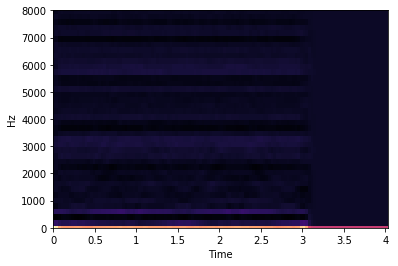

In [146]:
librosa.display.specshow(mfcc_norm, sr=16000, x_axis='time', y_axis='hz')

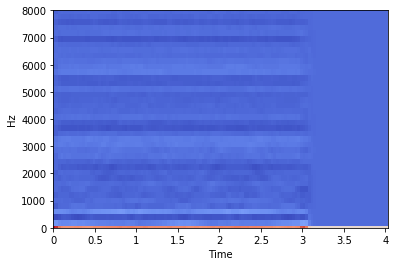

In [137]:
librosa.display.specshow(mfcc, sr=16000, x_axis='time', y_axis='hz')